In [1]:
import pandas as pd
# import numpy as np
# import datetime
from optbinning import OptimalBinning
from optbinning import BinningProcess
# from optbinning import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt



z = pd.read_csv(r"C:\Users\gromo\OneDrive\Documents\transactions_diy.csv")

# загружаем датасет Продажи

(CVXPY) Nov 22 05:07:01 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 22 05:07:01 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# смотрим датасет

z

,TrDte,BCode,ClientID,Item,ItemGroup,Quantity,Amount
0,01.09.2017,code000000001,client13166,sku8444,Скобяные изделия,1,29
1,01.09.2017,code000000001,client13166,sku12545,Оборудование для сада и дачи,1,329
2,01.09.2017,code000000001,client13166,sku3391,Инструменты,1,169
3,01.09.2017,code000000001,client13166,sku20444,Инструменты,2,578
4,01.09.2017,code000000002,client1239,sku29959,Скобяные изделия,1,329
...,...,...,...,...,...,...,...
1008683,31.10.2019,code000290228,client25258,sku5837,Скобяные изделия,1,89
1008684,31.10.2019,code000290228,client25258,sku26161,Стойматериалы,2,598
1008685,31.10.2019,code000290228,client25258,sku20658,Сантехника,1,159
1008686,31.10.2019,code000290229,client22472,sku16069,Столярные изделия,1,85


In [3]:
# смотрим какие типы данных
# замечаем, что TrDte - object

z.dtypes

TrDte        object
BCode        object
ClientID     object
Item         object
ItemGroup    object
Quantity      int64
Amount        int64
dtype: object

In [4]:
z['Month'] = z['TrDte']
z['Month'] = pd.to_datetime(z['Month'], dayfirst=True)
z['Month'] = z['Month'].dt.month

z['Year'] = z['TrDte']
z['Year'] = pd.to_datetime(z['Year'], dayfirst=True)
z['Year'] = z['Year'].dt.year

z['TrDte'] = pd.to_datetime(z['TrDte'], dayfirst=True)

In [42]:
def user_profile(df, act_date, act_date_reverse, first_date, second_date):
    global z2
    z1 = df # Визиты
    z1['sum_amount'] = z1.groupby(['ClientID', 'TrDte', 'Item', 'ItemGroup'])['Amount'].transform('sum')
    z1['sum_quantity'] = z1.groupby(['ClientID', 'TrDte', 'Item', 'ItemGroup'])['Quantity'].transform('sum')
    z1 = z1.groupby(['ClientID', 'TrDte', 'Item', 'ItemGroup']).agg({'Amount': "sum", 'Quantity': "sum"}).reset_index()

    z2 = z1 # Профиль клиента
    z2['TrDte'] = z2['TrDte'].shift(0)
    z2['act_date'] = act_date
    z2['act_date2'] = act_date_reverse
    z2 = z2[z2['TrDte'] < z2['act_date']] 
    z2['M'] = z2.groupby(['ClientID'])['Amount'].transform('sum')
    z2['F'] = z2.groupby(['ClientID'])['TrDte'].transform('count')
    z2['last_date'] = z2.groupby(['ClientID'])['TrDte'].transform('max')
    z2['R'] = pd.to_datetime(z2['last_date'], dayfirst=True) - pd.to_datetime(z2['act_date2'], dayfirst=True)
    z2['R'] = z2['R'].dt.days
    z2['R'] = z2['R'].abs() - 1
    z2['R_mean'] = z2['R'].mean()
    z2['variance_item'] = z2.groupby(['ClientID'])['Item'].transform('nunique')
    z2['variance_item_group'] = z2.groupby(['ClientID'])['ItemGroup'].transform('nunique')
    z2['for_last_date_amount'] = z2.groupby(['ClientID', 'TrDte'])['Amount'].transform('sum')
    z22 = z2
    z22 = z22[z22['TrDte'] == z22['last_date']]
    z22 = z22.drop_duplicates(subset=['ClientID'])
    z22 = z22.drop(['TrDte', 'ItemGroup', 'Item', 'Amount', 'Quantity', 'act_date',
                'M', 'F', 'last_date', 'R', 'variance_item', 'variance_item_group',
                ], axis=1)
    z22 = z22.rename(columns={'for_last_date_amount': 'last_date_amount'})
    z2 = pd.merge(z2, z22, how='left', on=['ClientID'])
    z2['fraction_last_date_amount'] = z2['last_date_amount'] / z2['M']
    weekend_purchases = z2[z2['TrDte'].dt.dayofweek.isin([5, 6])]
    weekend_purchases = weekend_purchases.drop_duplicates(subset=['ClientID', 'TrDte'])
    unique_visits_per_customer = weekend_purchases.groupby('ClientID').agg({'TrDte': 'nunique'})
    unique_visits_per_customer['weekdays_visits'] = unique_visits_per_customer['TrDte']
    unique_visits_per_customer = unique_visits_per_customer.drop(['TrDte'], axis=1)
    z2 = pd.merge(z2, unique_visits_per_customer, how='left', on=['ClientID'])
    z2['weekdays_visits'] = z2['weekdays_visits'].fillna(0).astype(int)

    not_weekend_purchases = z2[z2['TrDte'].dt.dayofweek.isin([0, 1, 2, 3, 4])]
    not_weekend_purchases = not_weekend_purchases.drop_duplicates(subset=['ClientID', 'TrDte'])
    unique_visits_per_customer_2 = not_weekend_purchases.groupby('ClientID').agg({'TrDte': 'nunique'})
    unique_visits_per_customer_2['not_weekdays_visits'] = unique_visits_per_customer_2['TrDte']
    unique_visits_per_customer_2 = unique_visits_per_customer_2.drop(['TrDte'], axis=1)
    z2 = pd.merge(z2, unique_visits_per_customer_2, how='left', on=['ClientID'])
    z2['not_weekdays_visits'] = z2['not_weekdays_visits'].fillna(0).astype(int)

    z2['fraction_weekdays_visits'] = z2['weekdays_visits'] / (z2['weekdays_visits'] + z2['not_weekdays_visits'])


    z2['max_amount'] = z2.groupby(['ClientID'])['Amount'].transform('max')
    z2['max_quantity'] = z2.groupby(['ClientID'])['Quantity'].transform('max')

    z2 = z2.drop_duplicates(subset=['ClientID'])

    z3 = z1 # События
    z3['1st_date'] = first_date
    z3['2nd_date'] = second_date

    z4 = z1 # Все клиенты
    z4['ClientID1'] = z4['ClientID']
    z4 = z4.drop_duplicates(subset='ClientID')
    z4 = z4[['ClientID', 'ClientID1']]

    z5 = z1 # Транзакции в период
    z5['ClientID2'] = z5['ClientID']
    z5['TrDte'] = pd.to_datetime(z5['TrDte'], dayfirst=True)
    z5['1st_date'] = z3['1st_date']
    z5['2nd_date'] = z3['2nd_date']
    z5['1st_date'] = pd.to_datetime(z5['1st_date'], dayfirst=True)
    z5['2nd_date'] = pd.to_datetime(z5['2nd_date'], dayfirst=True)
    z5 = z5[(z5['1st_date'] <= z5['TrDte']) & (z5['TrDte'] < z5['2nd_date'])]

    z6 = z5 # Клиенты с визитом в октябре 2019
    z6 = z6.drop_duplicates(subset='ClientID')
    z6 = z6[['ClientID', 'ClientID2']]

    z7 = pd.merge(z4, z6, how='left', on=['ClientID']) # Слияние
    z8 = z7 # слияние + событие (не переименовал нормально столбцы)
    z8 = z8.rename(columns={'ClientID2': 'fact'})

    z2 = pd.merge(z2, z8, how='left', on=['ClientID']) # профиль + событие
    z2['fact'] = z2['fact'].notna() 
    z2 = z2.drop(['TrDte', 'Item', 'ItemGroup', 'Amount', 'Quantity', 'act_date'
              , 'last_date', 'for_last_date_amount',
              'act_date2_y', 'ClientID1',
              'act_date2_x', 'not_weekdays_visits'],
             axis=1)
    return z2

In [43]:
# Профиль клиента на 01.09.2019 (обучающая выборка)

z9 = z
act_date1 = '09.01.2019'
act_date_reverse_1 = '01.09.2019'
first_date1 = '01.09.2019'
second_date1 = '01.10.2019'

user_profile(z9, act_date1, act_date_reverse_1, first_date1, second_date1)

C:\Users\gromo\AppData\Local\Temp\ipykernel_23004\2346243457.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z2['M'] = z2.groupby(['ClientID'])['Amount'].transform('sum')
C:\Users\gromo\AppData\Local\Temp\ipykernel_23004\2346243457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z2['F'] = z2.groupby(['ClientID'])['TrDte'].transform('count')
C:\Users\gromo\AppData\Local\Temp\ipykernel_23004\2346243457.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,ClientID,M,F,R,R_mean_x,variance_item,variance_item_group,R_mean_y,last_date_amount,fraction_last_date_amount,weekdays_visits,fraction_weekdays_visits,max_amount,max_quantity,fact
0,client1,2273,4,586,102.242297,4,2,102.242297,2273,1.000000,0,0.000000,1535,5,False
1,client10,4757,3,26,102.242297,3,1,102.242297,4757,1.000000,0,0.000000,4599,1,False
2,client100,7299,1,115,102.242297,1,1,102.242297,7299,1.000000,0,0.000000,7299,1,False
3,client1000,31792,32,7,102.242297,28,5,102.242297,1746,0.054919,4,0.333333,3534,70,True
4,client10000,8495,5,395,102.242297,5,1,102.242297,8495,1.000000,0,0.000000,5999,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39901,client9995,3677,3,273,102.242297,3,1,102.242297,1499,0.407669,2,1.000000,1999,1,False
39902,client9996,2499,1,395,102.242297,1,1,102.242297,2499,1.000000,0,0.000000,2499,1,False
39903,client9997,2398,2,81,102.242297,2,2,102.242297,119,0.049625,0,0.000000,2279,3,True
39904,client9998,38068,78,2,102.242297,36,12,102.242297,1173,0.030813,8,0.258065,4476,12,True


In [7]:
z10 = z2
train_1 = z10

In [44]:
# Профиль клиента на 01.10.2019

z11 = z
act_date2 = '10.01.2019'
act_date_reverse_2 = '01.10.2019'
first_date2 = '01.10.2019'
second_date2 = '01.11.2019'

user_profile(z11, act_date2, act_date_reverse_2, first_date2, second_date2)

C:\Users\gromo\AppData\Local\Temp\ipykernel_23004\2346243457.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z2['M'] = z2.groupby(['ClientID'])['Amount'].transform('sum')
C:\Users\gromo\AppData\Local\Temp\ipykernel_23004\2346243457.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z2['F'] = z2.groupby(['ClientID'])['TrDte'].transform('count')
C:\Users\gromo\AppData\Local\Temp\ipykernel_23004\2346243457.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,ClientID,M,F,R,R_mean_x,variance_item,variance_item_group,R_mean_y,last_date_amount,fraction_last_date_amount,weekdays_visits,fraction_weekdays_visits,max_amount,max_quantity,fact
0,client1,2273,4,616,106.048909,4,2,106.048909,2273,1.000000,0,0.000000,1535,5,False
1,client10,4757,3,56,106.048909,3,1,106.048909,4757,1.000000,0,0.000000,4599,1,False
2,client100,7299,1,145,106.048909,1,1,106.048909,7299,1.000000,0,0.000000,7299,1,True
3,client1000,36495,36,16,106.048909,31,5,106.048909,4703,0.128867,5,0.384615,3534,70,True
4,client10000,8495,5,425,106.048909,5,1,106.048909,8495,1.000000,0,0.000000,5999,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41191,client9995,3677,3,303,106.048909,3,1,106.048909,1499,0.407669,2,1.000000,1999,1,False
41192,client9996,2499,1,425,106.048909,1,1,106.048909,2499,1.000000,0,0.000000,2499,1,False
41193,client9997,17691,3,27,106.048909,3,2,106.048909,15293,0.864451,0,0.000000,15293,20,False
41194,client9998,38666,80,2,106.048909,37,13,106.048909,598,0.015466,9,0.281250,4476,12,False


In [9]:
z11 = z2
test_1 = z11[['R', 'F', 'M', 'variance_item_group', 'weekdays_visits', 'last_date_amount', 'fact', 'ClientID']]

In [10]:
# прогноз на ноябрь

z12 = z
act_date3 = '11.01.2019'
act_date_reverse_3 = '01.11.2019'
first_date3 = '01.11.2019'
second_date3 = '01.12.2019'

user_profile(z12, act_date3, act_date_reverse_3, first_date3, second_date3)

,ClientID,M,F,R,variance_item,variance_item_group,last_date_amount,fraction_last_date_amount,weekdays_visits,fraction_weekdays_visits,max_amount,max_quantity,fact
0,client1,2273,4,647,4,2,2273,1.000000,0,0.000000,1535,5,False
1,client10,4757,3,87,3,1,4757,1.000000,0,0.000000,4599,1,False
2,client100,8063,6,13,6,4,78,0.009674,0,0.000000,7299,2,False
3,client1000,44853,49,0,40,5,2139,0.047689,6,0.375000,3534,75,False
4,client10000,8495,5,456,5,1,8495,1.000000,0,0.000000,5999,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42741,client9995,3677,3,334,3,1,1499,0.407669,2,1.000000,1999,1,False
42742,client9996,2499,1,456,1,1,2499,1.000000,0,0.000000,2499,1,False
42743,client9997,17691,3,58,3,2,15293,0.864451,0,0.000000,15293,20,False
42744,client9998,38666,80,33,37,13,598,0.015466,9,0.281250,4476,12,False


In [11]:
z12 = z2 # прогноз на ноябрь

In [12]:
def opt_binning(df1, feature, event, df2):
    global x_train_t, x_test_t, y_train, y_test
    binning_process1 = BinningProcess(feature, max_n_bins=5)
    binning_process2 = BinningProcess(feature, max_n_bins=5)
    x1 = df1[feature]
    x2 = df1[event]
    x3 = df2[feature]
    x4 = df2[event]
    binning_process1.fit(x1, x2)
    binning_process2.fit(x3, x4)
    x_train_t = binning_process1.transform(x1, metric='woe')
    x_test_t = binning_process2.transform(x3, metric='woe')
    y_train = df1[event]
    y_test = df2[event]
    return x_train_t, x_test_t, y_train, y_test


In [13]:
# Для построения тривиальной модели первым этапом будет проведение биннига по test/train
train_1_1 = train_1[['R', 'F', 'M', 'variance_item_group', 'weekdays_visits', 'last_date_amount', 'fact', 'ClientID']]
test_1_1 = test_1[['R', 'F', 'M', 'variance_item_group', 'weekdays_visits', 'last_date_amount', 'fact', 'ClientID']]
feature_1 = ['R', 'F', 'M', 'variance_item_group', 'weekdays_visits', 'last_date_amount']
event_1 = 'fact'
opt_binning(train_1_1, feature_1, event_1, test_1_1)
x_train_1_1 = x_train_t
x_test_1_1 = x_test_t
y_train_1_1 = y_train
y_test_1_1 = y_test
y_test_1_1 = y_test_1_1.to_frame()
y_train_1_1 = y_train_1_1.to_frame()

d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Точность тривиальной модели по R:  0.8202495387901738
Значение AUC тривиальной модели по R  0.7753384493516862


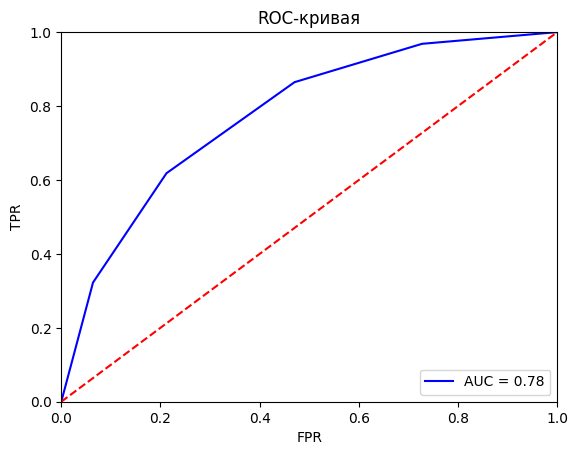

In [14]:
# Модель регрессии по R в качестве независимой переменной

log_reg_1 = LogisticRegression()
X1 = x_train_1_1['R'].to_frame()
y1 = y_train_1_1
X2 = x_test_1_1['R'].to_frame()
y2 = y_test_1_1

log_reg_1.fit(X1, y1)

y_predictions = log_reg_1.predict(X2)
y_predictions_proba = log_reg_1.predict_proba(X2)
accuracy = accuracy_score(y2, y_predictions)
roc_auc1 = roc_auc_score(y2, y_predictions_proba[:,1])
print('Точность тривиальной модели по R: ', accuracy)
print('Значение AUC тривиальной модели по R ', roc_auc1)

fpr, tpr, thresholds = roc_curve(y2, y_predictions_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()


In [15]:
train_1_2 = z10[['ClientID', 'R', 'fact', 'F', 'M', 'variance_item_group', 'weekdays_visits', 'last_date_amount']]
test_1_2 = z11[['ClientID', 'R', 'fact', 'F', 'M', 'variance_item_group', 'weekdays_visits', 'last_date_amount']]
z10[['F', 'M', 'R', 'weekdays_visits', 'variance_item_group', 'last_date_amount']].corr(method='pearson')

,F,M,R,weekdays_visits,variance_item_group,last_date_amount
F,1.000000,0.613597,-0.304814,0.778892,0.701987,-0.057153
M,0.613597,1.000000,-0.182789,0.492944,0.450223,0.155032
R,-0.304814,-0.182789,1.000000,-0.319533,-0.413137,0.069253
weekdays_visits,0.778892,0.492944,-0.319533,1.000000,0.654691,-0.090030
variance_item_group,0.701987,0.450223,-0.413137,0.654691,1.000000,-0.070545
last_date_amount,-0.057153,0.155032,0.069253,-0.090030,-0.070545,1.000000


Точность многофакторной модели логистической регрессии:  0.831852607049228
Значение AUC многофакторной модели логистической регрессии:  0.803835563159649
Отношение AUC тривиальной модели логистической регрессии к многофакторной модели логистической регрессии:  0.9645485779505092


d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


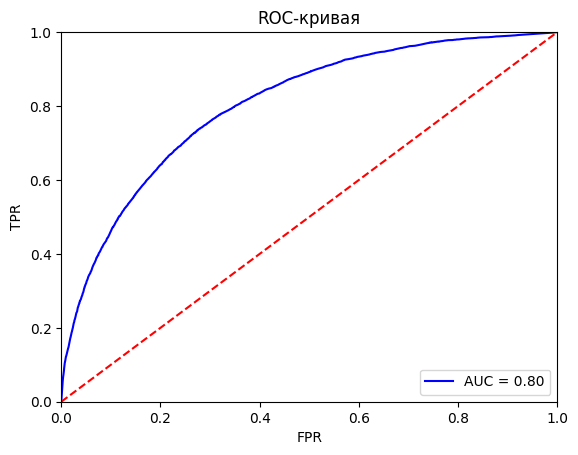

In [16]:
# Модель регрессии по 6 характеристикам
log_reg_3 = LogisticRegression()

X5 = x_train_1_1[['R', 'F', 'M',
                 'variance_item_group', 'weekdays_visits',
                'last_date_amount']]
y5 = y_train_1_1[['fact']]
X6 = x_test_1_1[['R', 'F', 'M',
                 'variance_item_group', 'weekdays_visits',
                'last_date_amount']]
y6 = y_test_1_1[['fact']]

log_reg_3.fit(X5, y5)

y_predictions3 = log_reg_3.predict(X6)
y_predictions3_proba = log_reg_3.predict_proba(X6)
accuracy3 = accuracy_score(y6, y_predictions3)
roc_auc3 = roc_auc_score(y6, y_predictions3_proba[:,1])
print('Точность многофакторной модели логистической регрессии: ', accuracy3)
print('Значение AUC многофакторной модели логистической регрессии: ', roc_auc3)
print('Отношение AUC тривиальной модели логистической регрессии к многофакторной модели логистической регрессии: ', roc_auc1 / roc_auc3)

fpr, tpr, thresholds = roc_curve(y6, y_predictions3_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()

In [17]:
# ЗАДАНИЕ
# Показатели долей визитов в выходных и долей трат в последнем визите
train_1_3 = z10[['ClientID', 'R', 'fact', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']]
test_1_3 = z11[['ClientID', 'R', 'fact', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']]

feature_2 = ['R', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']
event_2 = 'fact'

opt_binning(train_1_3, feature_2, event_2, test_1_3)

x_train_1_3 = x_train_t
x_test_1_3 = x_test_t

y_train_1_3 = y_train
y_test_1_3 = y_test
y_test_1_3 = y_test_1_3.to_frame()
y_train_1_3 = y_train_1_3.to_frame()

# Матрица корреляций
z10[['R', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']].corr()


,R,F,M,variance_item_group,fraction_weekdays_visits,fraction_last_date_amount
R,1.000000,-0.304814,-0.182789,-0.413137,0.005182,0.441079
F,-0.304814,1.000000,0.613597,0.701987,-0.014478,-0.443774
M,-0.182789,0.613597,1.000000,0.450223,-0.015990,-0.272373
variance_item_group,-0.413137,0.701987,0.450223,1.000000,-0.013147,-0.661543
fraction_weekdays_visits,0.005182,-0.014478,-0.015990,-0.013147,1.000000,0.018778
fraction_last_date_amount,0.441079,-0.443774,-0.272373,-0.661543,0.018778,1.000000


In [18]:
# Далее необходимо провести WOE и IV анализ, для этого будет использоваться Train-выборка
# Напишем функцию, дающую результаты бининга по 1 характеристике


def opt_binning_table(df1, feature, event):
    global binning_table1
    opt_binner = OptimalBinning(min_bin_size=0.05, max_n_bins=5)
    x1 = df1[feature]
    x2 = df1[event]
    opt_binner.fit_transform(x1, x2)
    binning_table1 = opt_binner.binning_table
    return binning_table1

In [19]:
# Рассчитаем бины для доли посещений в выходные
feature_5 = 'fraction_weekdays_visits'
event_5 = 'fact'

opt_binning_table(train_1_3, feature_5, event_5)

binning_table2 = binning_table1
binning_table2.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.02)",13749,0.344535,12462,1287,0.093607,0.812011,0.173797,0.021147
1,"[0.02, 0.33)",8019,0.200947,5203,2816,0.351166,-0.844441,0.180044,0.021860
2,"[0.33, 0.48)",6331,0.158648,4502,1829,0.288896,-0.557606,0.057882,0.007143
3,"[0.48, 0.97)",6875,0.172280,5666,1209,0.175855,0.086331,0.001250,0.000156
4,"[0.97, inf)",4932,0.123590,4542,390,0.079075,0.996617,0.088208,0.010591
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39906,1.000000,32375,7531,0.188718,,0.501181,0.060897


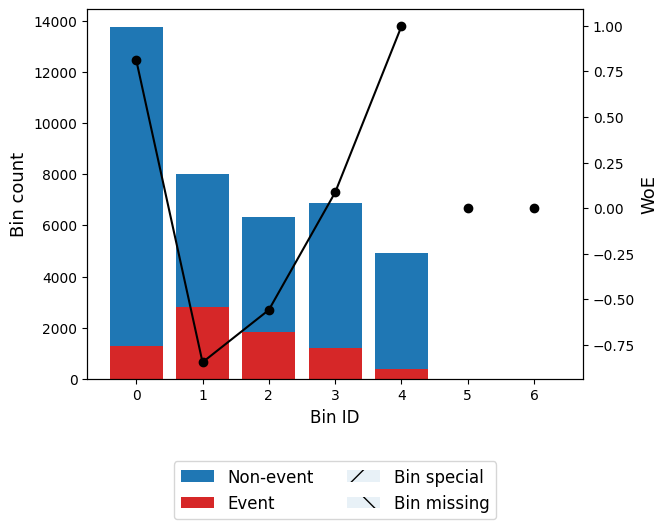

In [20]:
binning_table2.plot(metric="woe")

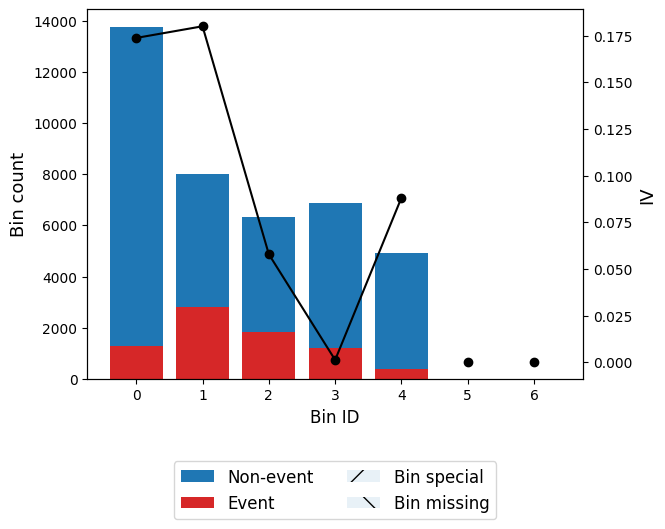

In [21]:
binning_table2.plot(metric="iv")

In [22]:
# Рассчитаем бины для доли стоимости последней покупки

feature_6 = 'fraction_last_date_amount'
event_6 = 'fact'

opt_binning_table(train_1_3, feature_6, event_6)

binning_table3 = binning_table1
binning_table3.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.02)",5716,0.143237,3649,2067,0.361617,-0.890004,0.143963,0.017424
1,"[0.02, 0.05)",5049,0.126522,3604,1445,0.286195,-0.544424,0.043855,0.005415
2,"[0.05, 0.21)",8421,0.211021,6539,1882,0.223489,-0.212909,0.010203,0.001273
3,"[0.21, 0.97)",8282,0.207538,6943,1339,0.161676,0.187452,0.006871,0.000858
4,"[0.97, inf)",12438,0.311682,11640,798,0.064158,1.221735,0.309801,0.036483
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,39906,1.000000,32375,7531,0.188718,,0.514694,0.061453


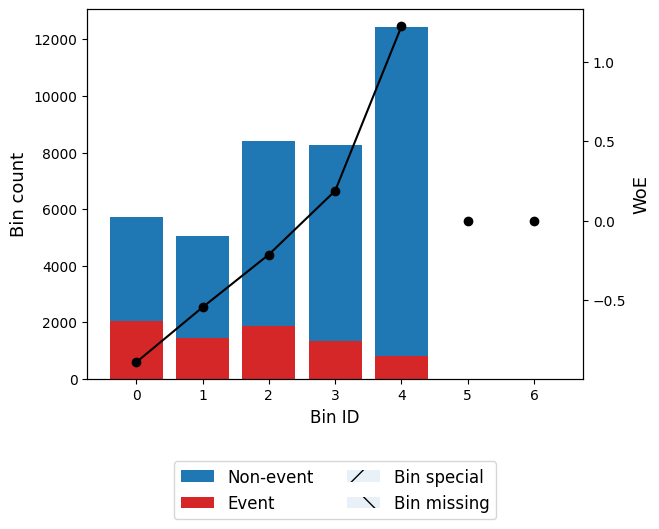

In [23]:
binning_table3.plot(metric="woe")

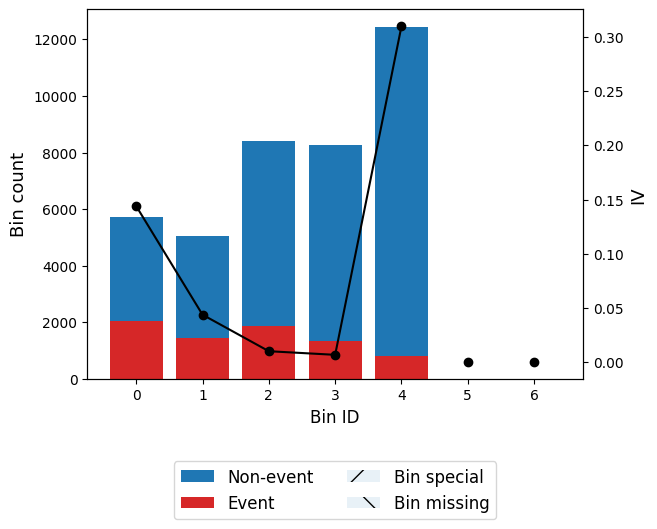

In [24]:
binning_table3.plot(metric="iv")

In [25]:
log_reg_5 = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_6 = LogisticRegression(penalty='l2')
class_for_reg = RandomForestClassifier()

X7 = train_1_3[['R', 'F', 'M',
                 'variance_item_group', 'fraction_weekdays_visits',
                'fraction_last_date_amount']]
y7 = train_1_3[['fact']]
X8 = test_1_3[['R', 'F', 'M',
                 'variance_item_group', 'fraction_weekdays_visits',
                'fraction_last_date_amount']]
y8 = test_1_3[['fact']]

Точность модели логистической регрессии с L1-регуляризацей:  0.831852607049228
Значение AUC модели логистической регрессии с L1-регуляризацей:  0.803835563159649
Отношение AUC тривиальной модели к многофакторной модели логистической регрессии с L1-регуляризацией:  0.9645485779505092


d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


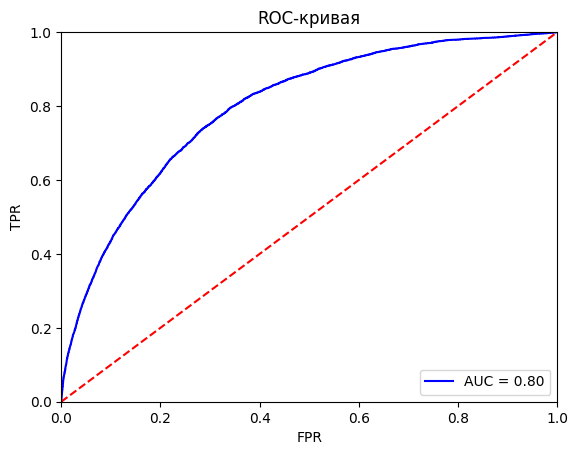

In [26]:
# Результаты Lasso

log_reg_5.fit(X7, y7)

y_predictions5 = log_reg_5.predict(X8)
y_predictions5_proba = log_reg_5.predict_proba(X8)
accuracy5 = accuracy_score(y8, y_predictions3)
roc_auc5 = roc_auc_score(y8, y_predictions3_proba[:,1])
print('Точность модели логистической регрессии с L1-регуляризацей: ', accuracy5)
print('Значение AUC модели логистической регрессии с L1-регуляризацей: ', roc_auc5)
print('Отношение AUC тривиальной модели к многофакторной модели логистической регрессии с L1-регуляризацией: ', roc_auc1 / roc_auc5)

fpr, tpr, thresholds = roc_curve(y8, y_predictions5_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()

d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Точность модели логистической регрессии с L2-регуляризацей:  0.8254442178852316
Значение AUC модели логистической регрессии с L2-регуляризацей:  0.7983301920108359
Отношение AUC тривиальной модели к многофакторной логистической регрессии с L2-регуляризацией  0.9712002090247419


d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


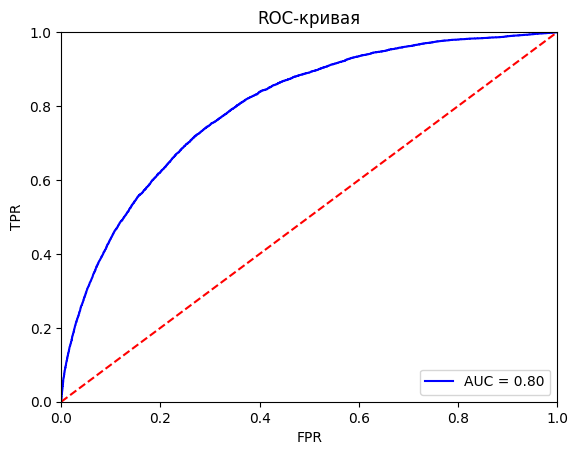

In [27]:
# Результаты Ridge 
log_reg_6.fit(X7, y7)

y_predictions6 = log_reg_6.predict(X8)
y_predictions6_proba = log_reg_6.predict_proba(X8)
accuracy6 = accuracy_score(y8, y_predictions6)
roc_auc6 = roc_auc_score(y8, y_predictions6_proba[:,1])
print('Точность модели логистической регрессии с L2-регуляризацей: ', accuracy6)
print('Значение AUC модели логистической регрессии с L2-регуляризацей: ', roc_auc6)
print('Отношение AUC тривиальной модели к многофакторной логистической регрессии с L2-регуляризацией ', roc_auc1 / roc_auc6)

fpr, tpr, thresholds = roc_curve(y8, y_predictions6_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc6)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()

d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Точность модели классификации случайных лесов:  0.8274589765996698
Значение AUC модели классификации случайных лесов:  0.7834547824679843
Отношение AUC тривиальной модели к модели классификации случайных лесов:  0.989640329859586


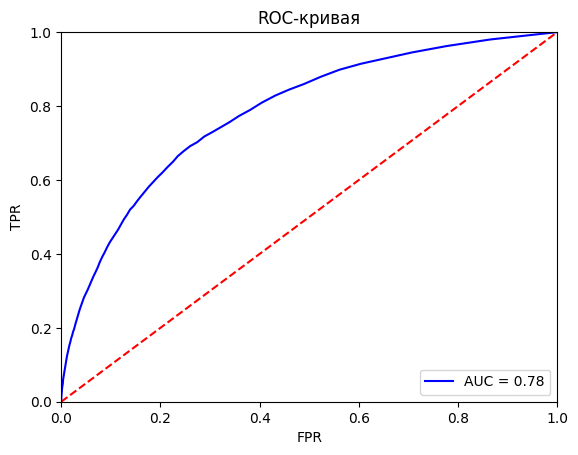

In [ ]:
# Результаты классификатора случайных лесов при бинах в качестве независимых показателей
class_for_reg.fit(X7, y7)

y_predictions7 = class_for_reg.predict(X8)
y_predictions7_proba = class_for_reg.predict_proba(X8)
accuracy7 = accuracy_score(y8, y_predictions7)
roc_auc7 = roc_auc_score(y8, y_predictions7_proba[:,1])
print('Точность модели классификации случайных лесов: ', accuracy7)
print('Значение AUC модели классификации случайных лесов: ', roc_auc7)
print('Отношение AUC тривиальной модели к модели классификации случайных лесов: ', roc_auc1 / roc_auc7)

fpr, tpr, thresholds = roc_curve(y8, y_predictions7_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()


In [29]:
# ПРОГНОЗ
# Для построения тривиальной модели первым этапом будет проведение биннига по test/train (бины от train)

train_1_4 = z10[['ClientID', 'R', 'fact', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']]
test_1_4 = z11[['ClientID', 'R', 'fact', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']]

feature_3 = ['R', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']
event_3 = 'fact'

opt_binning(train_1_4, feature_3, event_3, test_1_4)

x_train_1_4 = x_train_t
x_test_1_4 = x_test_t

y_train_1_4 = y_train
y_test_1_4 = y_test
y_test_1_4 = y_test_1_4.to_frame()
y_train_1_4 = y_train_1_4.to_frame()

Точность модели логистической регресии по R:  0.8202495387901738
Значение AUC модели логистической регресии по R:  0.7753384493516862


d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


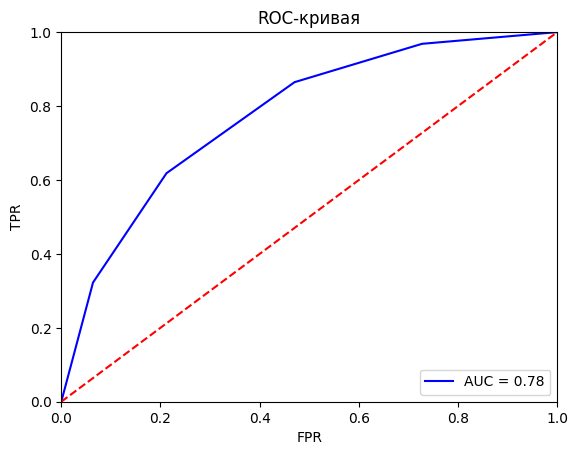

In [30]:
# Модель регрессии по R в качестве независимой переменной

log_reg_8 = LogisticRegression()

X13 = x_train_1_4['R'].to_frame()
y13 = y_train_1_4
X14 = x_test_1_4['R'].to_frame()
y14 = y_test_1_4

X15 = x_train_1_4[['R', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']]
y15 = y_train_1_4
X16 = x_test_1_4[['R', 'F', 'M', 'variance_item_group', 'fraction_weekdays_visits', 'fraction_last_date_amount']]
y16 = y_test_1_4



log_reg_8.fit(X13, y13)

y_predictions12 = log_reg_8.predict(X14)
y_predictions12_proba = log_reg_8.predict_proba(X14)
accuracy12 = accuracy_score(y14, y_predictions12)
roc_auc12 = roc_auc_score(y14, y_predictions12_proba[:,1])
print('Точность модели логистической регресии по R: ', accuracy12)
print('Значение AUC модели логистической регресии по R: ', roc_auc12)


fpr, tpr, thresholds = roc_curve(y14, y_predictions12_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc12)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()

In [31]:
log_reg_9 = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_10 = LogisticRegression(penalty='l2')
class_for_reg_3 = RandomForestClassifier()


d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Точность модели логистической регрессии с L1-регуляризацей:  0.831537042431304
Значение AUC модели логистической регресии с L1-регуляризацей:  0.8037751969778398


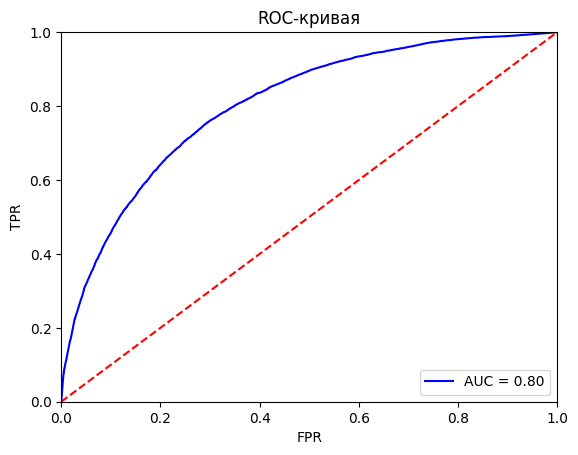

In [32]:
# Результаты Lasso

log_reg_9.fit(X15, y15)

y_predictions13 = log_reg_9.predict(X16)
y_predictions13_proba = log_reg_9.predict_proba(X16)
accuracy13 = accuracy_score(y14, y_predictions13)
roc_auc13 = roc_auc_score(y14, y_predictions13_proba[:,1])
print('Точность модели логистической регрессии с L1-регуляризацей: ', accuracy13)
print('Значение AUC модели логистической регресии с L1-регуляризацей: ', roc_auc13)

fpr, tpr, thresholds = roc_curve(y14, y_predictions13_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc13)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()

Точность модели логистической регрессии с L2-регуляризацей:  0.831537042431304
Значение AUC модели логистической регресии с L2-регуляризацей:  0.8037751969778398


d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


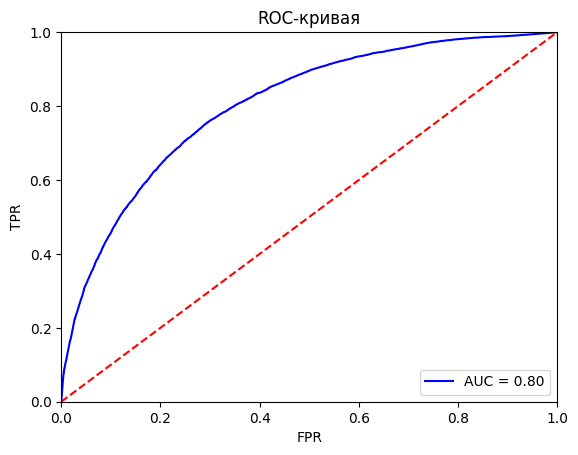

In [33]:
# Результаты Ridge при бинах в качестве независимых показателей

log_reg_10.fit(X15, y15)

y_predictions14 = log_reg_10.predict(X16)
y_predictions14_proba = log_reg_10.predict_proba(X16)
accuracy14 = accuracy_score(y14, y_predictions13)
roc_auc14 = roc_auc_score(y14, y_predictions13_proba[:,1])
print('Точность модели логистической регрессии с L2-регуляризацей: ', accuracy14)
print('Значение AUC модели логистической регресии с L2-регуляризацей: ', roc_auc14)

fpr, tpr, thresholds = roc_curve(y14, y_predictions13_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc13)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()

d:\SPBPU\1_course\1_sem\MLOps\second_task\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Точность модели классификации случайных лесов:  0.8141809884454801
Значение AUC модели классификации случайных лесов:  0.7562094360772919


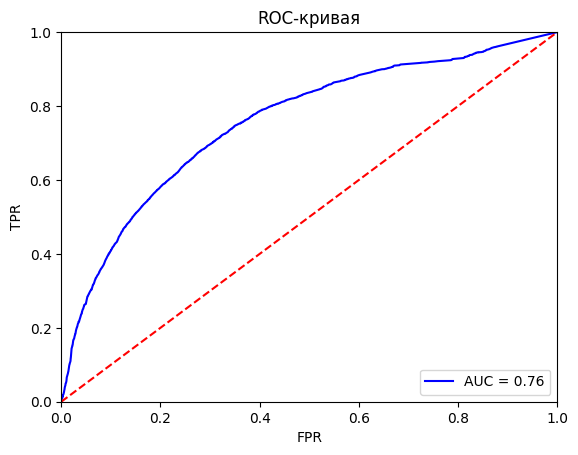

In [34]:
# Результаты классификатора случайных лесов
class_for_reg_3.fit(X15, y15)

y_predictions15 = class_for_reg_3.predict(X16)
y_predictions15_proba = class_for_reg_3.predict_proba(X16)
accuracy15 = accuracy_score(y14, y_predictions15)
roc_auc15 = roc_auc_score(y14, y_predictions15_proba[:,1])
print('Точность модели классификации случайных лесов: ', accuracy15)
print('Значение AUC модели классификации случайных лесов: ', roc_auc15)

fpr, tpr, thresholds = roc_curve(y14, y_predictions15_proba[:,1])

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc15)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC-кривая')
plt.show()